In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Aprendizaje no supervisado parte 1 - transformación


Muchas formas de aprendizaje no supervisado, como reducción de dimensionalidad, aprendizaje de variedades y extracción de características, encuentran una nueva representación de los datos de entrada sin ninguna variable adicional (al contrario que en aprendizaje supervisado, los algoritmos nos supervisados no requieren o consideran variables objetivo como en los casos anteriores de clasificación y regresión). 

<img src="figures/unsupervised_workflow.svg" width="100%">

Un ejemplo muy básico es el rescalado de los datos, que es un requisito para muchos algoritmos de aprendizaje automático ya que no son invariantes a escala (aunque el reescalado de los datos es más bien un método de preprocesamiento ya que no hay mucho *aprendizaje*). Existen muchas técnicas de reescalado y, en el siguiente ejemplo, veremos un método particular que se denomina "estandarización". Con este método, reescalaremos los datos para que cada característica esté centrada en el cero (media=0) con varianza unitaria (desviación típica = 1).

Por ejemplo, si tenemos un dataset de una dimensión con los datos $[1, 2, 3, 4, 5]$, los valores estandarizados serían:

- 1 -> -1.41
- 2 -> -0.71
- 3 -> 0.0
- 4 -> 0.71
- 5 -> 1.41

los cuales se pueden obtener con la ecuación $x_{standardized} = \frac{x - \mu_x}{\sigma_x}$, donde $\mu$ es la media muestral, y $\sigma$ la desviación típica.

In [3]:
ary = np.array([1, 2, 3, 4, 5])
ary_standardized = (ary - ary.mean()) / ary.std()
ary_standardized

array([-1.41421356, -0.70710678,  0.        ,  0.70710678,  1.41421356])

Aunque la estandarización es un método muy básico (y su código es simple, como acabamos de ver) scikit-learn implemente una clase `StandardScaler` para realizar los cálculos. En secciones posteriores veremos porqué es mejor usar la interfaz de scikit-learn que el código anterior.

Aplicar un algoritmo de preprocesamiento tiene una interfaz muy similar a la que se usa para los algoritmos supervisados que hemos visto hasta el momento. Para coger más práctica con la interfaz ``Transformer`` de scikit-learn, vamos a empezar cargando el dataset iris y reescalándolo:


In [10]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
print(X_train.shape)

(112, 4)


El dataset iris no está "centrado", es decir, tiene media distinta de cero y desviación típica distinta para cada componente:


In [8]:
print("media : %s " % X_train.mean(axis=0))
print("desviacion típica : %s " % X_train.std(axis=0))

media : [5.88660714 3.05178571 3.79642857 1.22321429] 
desviacion típica : [0.86741565 0.43424445 1.79264014 0.77793019] 


Para usar un método de preprocesamiento, primero importamos el estimador, en este caso, ``StandardScaler``, y luego lo instanciamos:
    

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

Como con los algoritmos de regresión y clasificación, llamamos a ``fit`` para aprender el modelo de los datos. Como es un modelo no supervisado, solo le pasamos ``X``, no ``y``. Esto simplemente calcula la media y la desviación típica.

In [12]:
scaler.fit(X_train)
print(scaler.mean_)
print(scaler.scale_)

[5.88660714 3.05178571 3.79642857 1.22321429]
[0.86741565 0.43424445 1.79264014 0.77793019]


Ahora podemos reescalar los datos aplicando el método ``transform`` (no ``predict``):

In [13]:
X_train_scaled = scaler.transform(X_train)

``X_train_scaled`` tiene el mismo número de ejemplos y características, pero la media ha sido restada y todos las variables tienen desviación típica unitaria:

In [14]:
print(X_train_scaled.shape)

(112, 4)


In [15]:
print("media : %s " % X_train_scaled.mean(axis=0))
print("desviación típica : %s " % X_train_scaled.std(axis=0))

media : [ 1.21331516e-15 -4.41115398e-17  7.13714802e-17 -3.66770106e-16] 
desviación típica : [1. 1. 1. 1.] 


Resumiendo, el método `fit` ajusta el estimador a los datos que le proporcionamos. En este paso, el estimador estima los parámetros de los datos (p.ej. media y desviación típica). Después, si aplicamos `transform`, estos parámetros se utilizan para transformar un dataset (**el método `transform` no modifica los parámetros**).

Es importante indicar que la misma transformación se utiliza para los datos de entrenamiento y de test. Como consecuencia, la media y desviación típica en test no tienen porque ser 0 y 1:

In [16]:
X_test_scaled = scaler.transform(X_test)
print("medias de los datos de test: %s" % X_test_scaled.mean(axis=0))

medias de los datos de test: [-0.19692712  0.05042896 -0.08461917 -0.12117658]


La transformación en entrenamiento y test debe ser siempre la misma, para que tenga sentido lo que estamos haciendo. Por ejemplo:

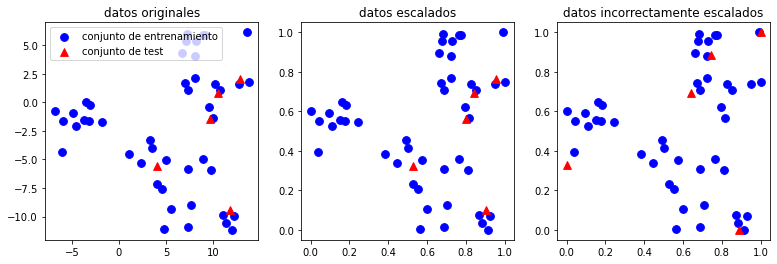

In [7]:
from figures import plot_relative_scaling
plot_relative_scaling()


Hay muchas formas de escalar los datos. La más común es el ``StandardScaler`` que hemos mencionada, pero hay otras clases útiles como:
- ``MinMaxScaler``: reescalar los datos para que se ajusten a un mínimo y un máximo (normalmente, entre 0 y 1)
- ``RobustScaler``: utilizar otros estadísticos más robustos como la mediana o los cuartiles, en lugar de la media y la desviación típica.
- ``Normalizer``: normaliza cada ejemplo individualmente para que tengan como norma (L1 o L2) la unidad. Por defecto, se utiliza L2.

C:\Users\lucas\anaconda3.1\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.tree.export module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


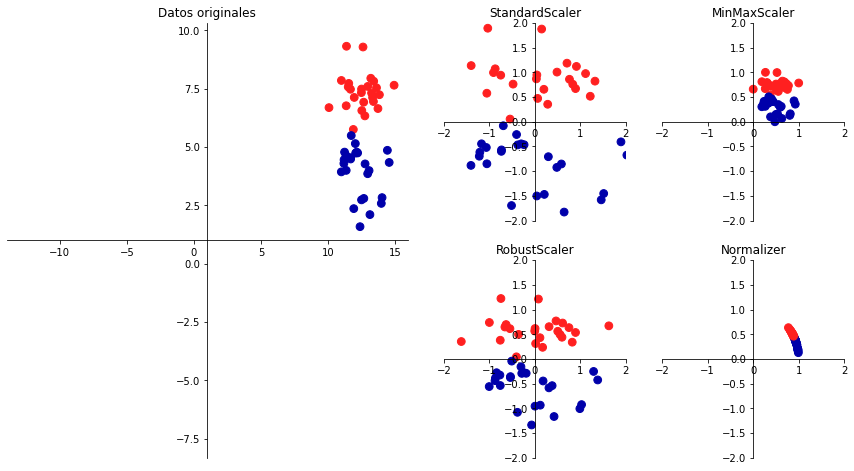

In [6]:
from figures import plot_scaling
plot_scaling()

Análisis de componentes principales
============================

Una transformación no supervisada algo más interesante es el Análisis de Componentes Principales (*Principal Component Analysis*, PCA). Es una técnica para reducir la dimensionalidad de los datos, creando una proyección lineal. Es decir, encontramos características nuevas para representar los datos que son una combinación lineal de los datos originales (lo cual es equivalente a rotar los datos). De esta forma, podemos pensar en el PCA como una proyección de nuestros datos en un *nuevo* espacio de características.

La forma en que el PCA encuentra estas nuevas direcciones es buscando direcciones de máxima varianza. Normalmente, solo unas pocas componentes principales son capaces explicar la mayor parte de la varianza y el resto se pueden obviar. La premisa es reducir el tamaño (dimensionalidad) del dataset, al mismo tiempo que se captura la mayor parte de información. Hay muchas razones por las que es bueno reducir la dimensionalidad de un dataset: reducimos el coste computacional de los algoritmos de aprendizaje, reducimos el espacio en disco y ayudamos a combatir la llamada *maldición de la dimensionalidad* (*curse of dimensionality*), que discutiremos después más a fondo.

Para ilustrar como puede funcionar una rotación, primero la mostraremos en datos bidimensionales y mantendremos las dos componentes principales:


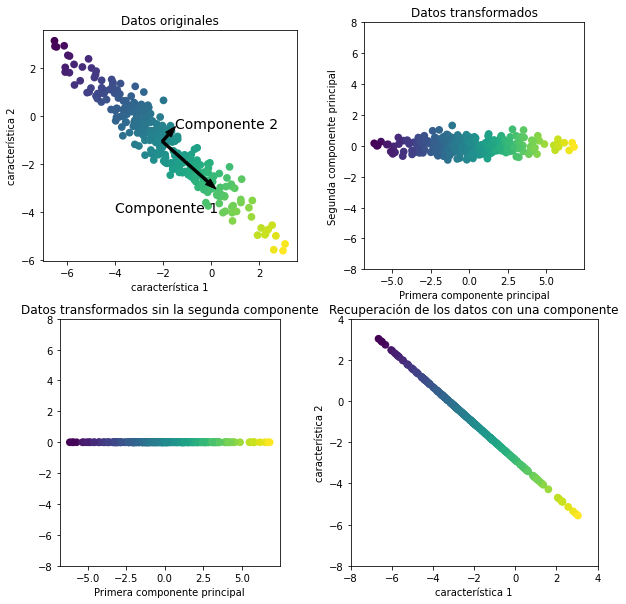

In [8]:
from figures import plot_pca_illustration
plot_pca_illustration()

Veamos ahora todos los pasos con más detalle.
Creamos una nube Gaussiana de puntos, que es rotada:

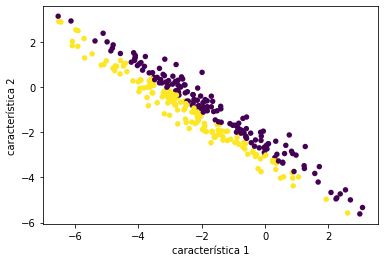

In [9]:
rnd = np.random.RandomState(5)
X_ = rnd.normal(size=(300, 2))
X_blob = np.dot(X_, rnd.normal(size=(2, 2)))+rnd.normal(size=2)
y = X_[:, 0] > 0
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y, linewidths=0, s=30)
plt.xlabel("característica 1")
plt.ylabel("característica 2");

Como siempre, instanciamos nuestro modelo PCA. Por defecto, todas las componentes se mantienen:

In [10]:
from sklearn.decomposition import PCA
pca = PCA()

Después, ajustamos el PCA a los datos. Como PCA es un algoritmo no supervisado, no hay que suministrar ninguna ``y``.

In [11]:
pca.fit(X_blob)

PCA()

Después podemos transformar los datos, proyectando en las componentes principales:

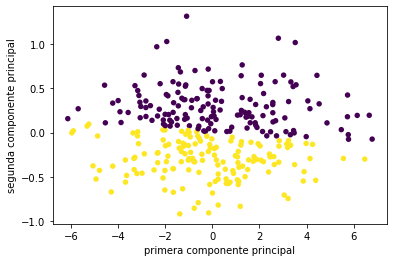

In [12]:
X_pca = pca.transform(X_blob)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, linewidths=0, s=30)
plt.xlabel("primera componente principal")
plt.ylabel("segunda componente principal");

Ahora vamos a usar una sola componente principal

In [13]:
pca = PCA(n_components=1).fit(X_blob)

In [14]:
X_blob.shape

(300, 2)

In [15]:
X_pca = pca.transform(X_blob)
print(X_pca.shape)

(300, 1)


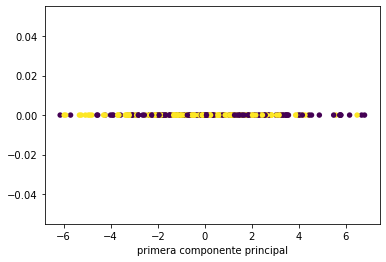

In [16]:
plt.scatter(X_pca[:, 0], np.zeros(X_pca.shape[0]), c=y, linewidths=0, s=30)
plt.xlabel("primera componente principal");

El PCA encuentra sitúa la primera componente en la diagonal de los datos (máxima variabilidad) y la segunda perpendicular a la primera. Las componentes siempre son ortogonales entre si.

Reducción de la dimensionalidad para visualización con PCA
-------------------------------------------------------------
Considera el dataset de dígitos. No puede ser visualizado en un único gráfico 2D, porque tiene 64 características. Vamos a extraer 2 dimensiones para visualizarlo, utilizando este [ejemplo](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html) de scikit learn.

Obteniendo la proyección PCA


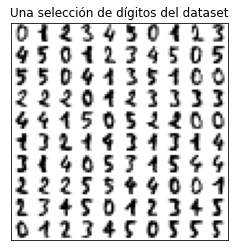

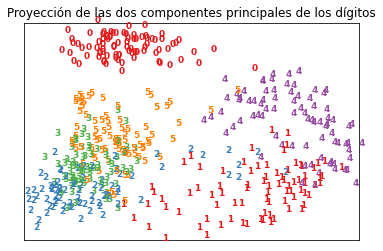

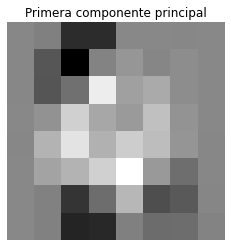

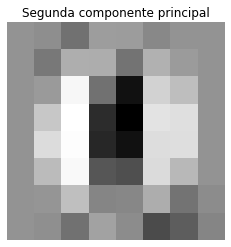

In [17]:
from figures import digits_plot

digits_plot()

Ten en cuenta que esta proyección se determinó *sin* ninguna información sobre las etiquetas (representadas por colores): en este sentido, este aprendizaje es **no supervisado**.  No obstante, vemos que la proyección nos da pistas sobre la distribución de los dígitos en el espacio de características.

<div class="alert alert-success">
    <b>EJERCICIO</b>:
     <ul>
      <li>
        Visualizar el dataset iris utilizando las dos primeras componentes principales y comparar a la visualización utilizando dos de las características originales.
      </li>
    </ul>
</div>

In [9]:
from sklearn.datasets import load_iris
from sklearn import datasets, decomposition
from matplotlib import offsetbox

iris = load_iris()
X = iris.data
y = iris.target
print (X.shape)

(150, 4)


In [47]:
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(iris.target[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 1e5:
                # don't show points that are too close
                # set a high threshold to basically turn this off
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(iris.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

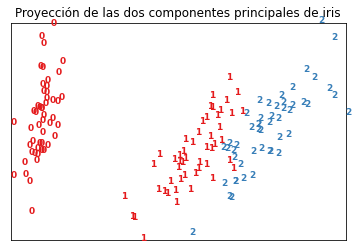

In [49]:
pca = decomposition.PCA(n_components=2).fit(X)
X_pca = pca.transform(X)

plot_embedding(X_pca, "Proyección de las dos componentes principales de iris")
plt.show()




In [54]:
## Cargamos los datos necesarios
iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

In [ ]:
## Transformamos los datos usando dos componentes
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

Text(0.5, 1.0, 'PCA of IRIS dataset')

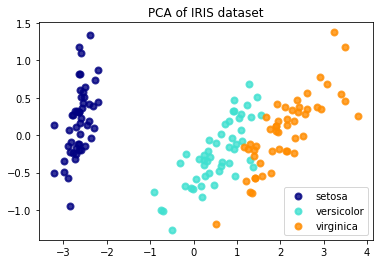

In [55]:
## Ploteamos los resultados

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')